In [1]:
#skip if you already installed it
# pip install tensorflow-addons


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statistics as st
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import seaborn as sn
from tensorflow_addons import losses
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import confusion_matrix, classification_report


In [3]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")


In [4]:
#fill the empty cells in column bmi with the mean of the columns
#we don't have a big data so it's better to fill the null not ignoring them
df.bmi.fillna(axis=0,inplace=True,value=df.bmi.mean())

In [5]:
df.describe()
# features with low std will have low effect on target

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.698018,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.400000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [6]:
positiveStroke = df[df.stroke == 1]
negativeStroke = df[df.stroke == 0]

print(positiveStroke.count())
print('----------------------------------------')
print(negativeStroke.count())


id                   249
gender               249
age                  249
hypertension         249
heart_disease        249
ever_married         249
work_type            249
Residence_type       249
avg_glucose_level    249
bmi                  249
smoking_status       249
stroke               249
dtype: int64
----------------------------------------
id                   4861
gender               4861
age                  4861
hypertension         4861
heart_disease        4861
ever_married         4861
work_type            4861
Residence_type       4861
avg_glucose_level    4861
bmi                  4861
smoking_status       4861
stroke               4861
dtype: int64


In [7]:
#remove id column
df.drop('id', axis=1, inplace=True)

In [8]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

In [9]:
#print the possible values of object columns
def print_unique_col_values(df):
    for column in df:
        if df[column].dtypes == 'object':
            print(f'{column}: {df[column].unique()}')

In [10]:
print_unique_col_values(df)

gender: ['Male' 'Female' 'Other']
ever_married: ['Yes' 'No']
work_type: ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type: ['Urban' 'Rural']
smoking_status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [11]:
#convert ever_married from string to binary
df['ever_married'].replace({'Yes': 1, 'No': 0}, inplace=True)


In [12]:
df.ever_married.unique()

array([1, 0], dtype=int64)

In [13]:
#convert Residence_type from string to binary
#1 meand urban
df['Residence_type'].replace({'Urban': 1, 'Rural': 0}, inplace=True)


In [14]:
df.Residence_type.unique()


array([1, 0], dtype=int64)

In [15]:
df.columns

Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

if we have gender column with three possible values (male,female,other)
we remove that columns and replace it with three columns male,female and other and if the tuple is male then female and other value will be zero and male value will be one

gender-> male   female   other
male-> 1 0 0
female-> 0 1 0

and same for other columns which has string values

In [16]:
df = pd.get_dummies(data=df, columns=[
    'gender', 'work_type', 'smoking_status'])
df.columns


Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Female',
       'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [17]:
df.head(10)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,67.0,0,1,1,1,228.69,36.600000,1,0,1,0,0,0,1,0,0,0,1,0,0
1,61.0,0,0,1,0,202.21,28.893237,1,1,0,0,0,0,0,1,0,0,0,1,0
2,80.0,0,1,1,0,105.92,32.500000,1,0,1,0,0,0,1,0,0,0,0,1,0
3,49.0,0,0,1,1,171.23,34.400000,1,1,0,0,0,0,1,0,0,0,0,0,1
4,79.0,1,0,1,0,174.12,24.000000,1,1,0,0,0,0,0,1,0,0,0,1,0
5,81.0,0,0,1,1,186.21,29.000000,1,0,1,0,0,0,1,0,0,0,1,0,0
6,74.0,1,1,1,0,70.09,27.400000,1,0,1,0,0,0,1,0,0,0,0,1,0
7,69.0,0,0,0,1,94.39,22.800000,1,1,0,0,0,0,1,0,0,0,0,1,0
8,59.0,0,0,1,0,76.15,28.893237,1,1,0,0,0,0,1,0,0,1,0,0,0
9,78.0,0,0,1,1,58.57,24.200000,1,1,0,0,0,0,1,0,0,1,0,0,0


In [18]:
#scalling improve the speed of traing the model and improve the performance
#scalling number to be in range (0-1)
cols_to_scale = ['age', 'avg_glucose_level', 'bmi']

scaler = MinMaxScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])


In [19]:
df.head(20)

,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,0.816895,0,1,1,1,0.801265,0.301260,1,0,1,0,0,0,1,0,0,0,1,0,0
1,0.743652,0,0,1,0,0.679023,0.212981,1,1,0,0,0,0,0,1,0,0,0,1,0
2,0.975586,0,1,1,0,0.234512,0.254296,1,0,1,0,0,0,1,0,0,0,0,1,0
3,0.597168,0,0,1,1,0.536008,0.276060,1,1,0,0,0,0,1,0,0,0,0,0,1
4,0.963379,1,0,1,0,0.549349,0.156930,1,1,0,0,0,0,0,1,0,0,0,1,0
5,0.987793,0,0,1,1,0.605161,0.214204,1,0,1,0,0,0,1,0,0,0,1,0,0
6,0.902344,1,1,1,0,0.069107,0.195876,1,0,1,0,0,0,1,0,0,0,0,1,0
7,0.841309,0,0,0,1,0.181285,0.143184,1,1,0,0,0,0,1,0,0,0,0,1,0
8,0.719238,0,0,1,0,0.097082,0.212981,1,1,0,0,0,0,1,0,0,1,0,0,0
9,0.951172,0,0,1,1,0.015927,0.159221,1,1,0,0,0,0,1,0,0,1,0,0,0


In [20]:
stroke_df=df[df.stroke==1]
nonstroke_df=df[df.stroke==0]

In [21]:
def get_score(model,X_train,y_train,X_test,y_test):
    model.fit(X_train,y_train)
    return model.score(X_test,y_test)

In [22]:
#function to get the data and make nn model
def ANN(X_train, y_train, X_test, y_test, loss, weights):
    model = keras.Sequential([
        keras.layers.Dense(19, input_dim=19, activation='relu'),
        keras.layers.Dense(10, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss=loss, metrics=['accuracy'])

    if weights == -1:
        model.fit(X_train, y_train, epochs=100)
    else:
        model.fit(X_train, y_train, epochs=100, class_weight=weights)

    print(model.evaluate(X_test, y_test))

    y_preds = model.predict(X_test)
    y_preds = np.round(y_preds)

    print("Classification Report: \n", classification_report(y_test, y_preds))

    return y_preds


In [23]:
count_class_0, count_class_1 = df.stroke.value_counts()

print(count_class_0)
print(count_class_1)


4861
249


we have 4861 without stroke and 249 with
if we trained the model with this impalance almost the result will be always 0 and the accuracy will be high
first we will repeat the data with stroke so the number of tuples will be equal in both but will be there a dublications(this solution if frequently better when data is small)

In [24]:
# Oversample 1-class and concat the DataFrames of both classes
df_class_1_over = stroke_df.sample(count_class_0, replace=True)
df_test_over = pd.concat([nonstroke_df, df_class_1_over], axis=0)

print('Random over-sampling:')
print(df_test_over.stroke.value_counts())

Random over-sampling:
0    4861
1    4861
Name: stroke, dtype: int64


In [25]:
X = df_test_over.drop('stroke', axis='columns')
y = df_test_over['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y)


In [26]:
y_train.value_counts()


1    3889
0    3888
Name: stroke, dtype: int64

In [27]:
df.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'Residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'gender_Female',
       'gender_Male', 'gender_Other', 'work_type_Govt_job',
       'work_type_Never_worked', 'work_type_Private',
       'work_type_Self-employed', 'work_type_children',
       'smoking_status_Unknown', 'smoking_status_formerly smoked',
       'smoking_status_never smoked', 'smoking_status_smokes'],
      dtype='object')

In [28]:
bag_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                              n_estimators=100, max_samples=0.8, oob_score=True, random_state=0
                              )
scores = cross_val_score(bag_model, X_train, y_train, cv=5)
bag_model.fit(X_train,y_train)
print(scores)
print(scores.mean())



[0.97750643 0.97365039 0.98392283 0.96784566 0.97234727]
0.9750545135932682


In [29]:
y_pred = bag_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       973
           1       0.97      1.00      0.99       972

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945



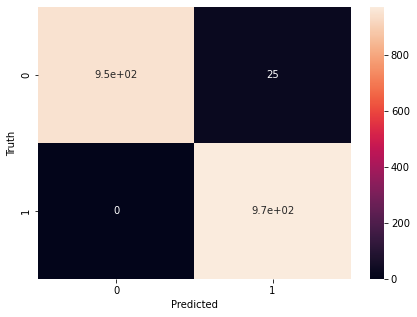

In [30]:
plt.figure(figsize=(7,5))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test,y_pred))

In [31]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=50)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))


0.7825192802056555


d:\anacona3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.80      0.76      0.78       973
           1       0.77      0.81      0.79       972

    accuracy                           0.78      1945
   macro avg       0.78      0.78      0.78      1945
weighted avg       0.78      0.78      0.78      1945



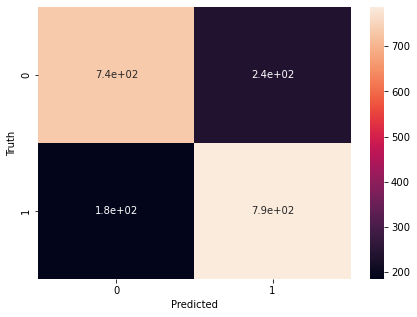

In [33]:
plt.figure(figsize=(7,5))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test,y_pred))

In [34]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))

0.8946015424164524


In [35]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.79      0.88       973
           1       0.83      1.00      0.90       972

    accuracy                           0.89      1945
   macro avg       0.91      0.89      0.89      1945
weighted avg       0.91      0.89      0.89      1945



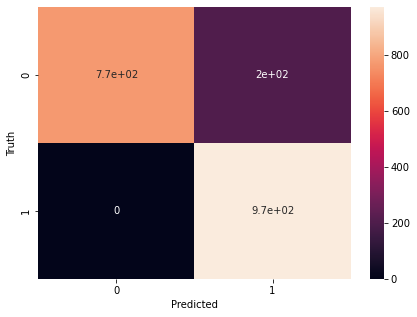

In [36]:
plt.figure(figsize=(7,5))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test,y_pred))

In [37]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
ridge_reg.fit(X_train, y_train)

print(ridge_reg.score(X_test, y_test))

0.356268158185004


In [38]:
# from sklearn.model_selection import KFold
# from sklearn.svm import SVC
# scores_l = []
# scores_svm = []
# scores_rf = []

# kf = KFold(n_splits=3)

# for train_index, test_index in kf.split(df):
#     scores_l.append(get_score(LogisticRegression(),
#                     X_train, y_train, X_test, y_test))
#     scores_svm.append(get_score(SVC(), X_train, y_train, X_test, y_test))
#     scores_rf.append(get_score(RandomForestClassifier(),
#                      X_train, y_train, X_test, y_test))

# print(scores_l)
# print(scores_svm)
# print(scores_rf)


In [39]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=40)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.996401028277635


In [40]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       973
           1       0.99      1.00      1.00       972

    accuracy                           1.00      1945
   macro avg       1.00      1.00      1.00      1945
weighted avg       1.00      1.00      1.00      1945



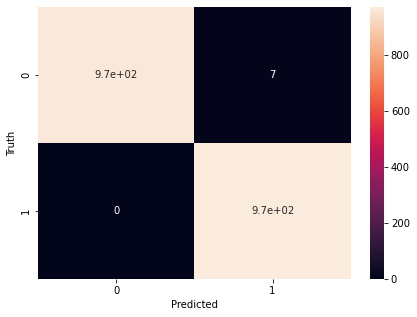

In [41]:
plt.figure(figsize=(7,5))
sn.heatmap(cm,annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.82      0.76      0.79       973
           1       0.78      0.83      0.81       972

    accuracy                           0.80      1945
   macro avg       0.80      0.80      0.80      1945
weighted avg       0.80      0.80      0.80      1945

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       973
           1       0.98      1.00      0.99       972

    accuracy                           0.99      1945
   macro avg       0.99      0.99      0.99      1945
weighted avg       0.99      0.99      0.99      1945



d:\anacona3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\anacona3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result

              precision    recall  f1-score   support

           0       0.80      0.75      0.78       973
           1       0.77      0.81      0.79       972

    accuracy                           0.78      1945
   macro avg       0.78      0.78      0.78      1945
weighted avg       0.78      0.78      0.78      1945

                 model  best_score                 best_params
0                  svm    0.791308  {'C': 20, 'kernel': 'rbf'}
1        random_forest    0.984698        {'n_estimators': 10}
2  logistic_regression    0.772536                    {'C': 1}


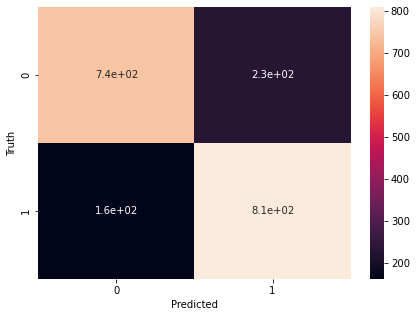

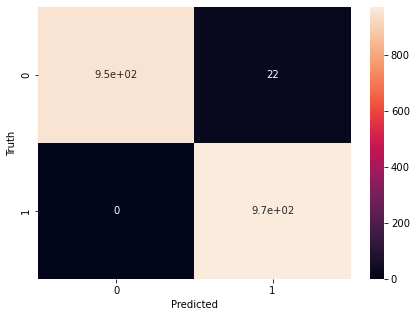

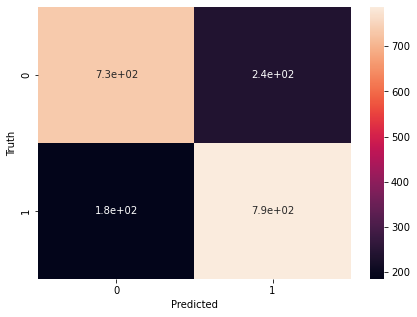

In [42]:
from sklearn.model_selection import GridSearchCV
model_param = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params': {
            'C': [1, 10, 20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [1, 5, 10]
        }
    }
}

scores = []
for model_name, mp in model_param.items():
    clf = GridSearchCV(mp['model'], mp['params'],
                       cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)

    plt.figure(figsize=(7, 5))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(y_test, y_pred))

dfr = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(dfr)


# i don't remeber what is the meaning of f1-score but it's better to be high


In [43]:
#nn model
loss = keras.losses.BinaryCrossentropy()
weights = -1
y_preds = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)


Epoch 1/100
244/244 [==============================] - 2s 3ms/step - loss: 0.6500 - accuracy: 0.6366
Epoch 2/100
244/244 [==============================] - 1s 3ms/step - loss: 0.5470 - accuracy: 0.7477
Epoch 3/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4972 - accuracy: 0.7741
Epoch 4/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4785 - accuracy: 0.7809
Epoch 5/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4682 - accuracy: 0.7899
Epoch 6/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4612 - accuracy: 0.7917
Epoch 7/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4575 - accuracy: 0.7934
Epoch 8/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4508 - accuracy: 0.7939
Epoch 9/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4494 - accuracy: 0.7949
Epoch 10/100
244/244 [==============================] - 1s 3ms/step - loss: 0.4467 - accura

              precision    recall  f1-score   support

           0       0.80      0.75      0.78       973
           1       0.77      0.81      0.79       972

    accuracy                           0.78      1945
   macro avg       0.78      0.78      0.78      1945
weighted avg       0.78      0.78      0.78      1945



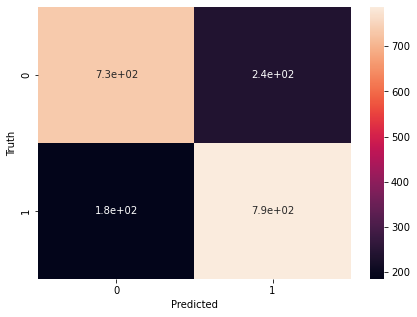

In [44]:
cm = confusion_matrix(y_test, y_pred)
# print(cm)

plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))


second solution is to take a sample from non stroke data
so there willn't be a duplications but we will lose some data

In [45]:
# Undersample 0-class and concat the DataFrames of both class
df_class_0_under = nonstroke_df.sample(count_class_1)
df_test_under = pd.concat([df_class_0_under, stroke_df], axis=0)

print('Random under-sampling:')
print(df_test_under.stroke.value_counts())


Random under-sampling:
0    249
1    249
Name: stroke, dtype: int64


In [46]:
from sklearn.model_selection import train_test_split
X = df_test_under.drop('stroke', axis='columns')
y = df_test_under['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=15, stratify=y)


In [47]:
X_test.count()


age                               100
hypertension                      100
heart_disease                     100
ever_married                      100
Residence_type                    100
avg_glucose_level                 100
bmi                               100
gender_Female                     100
gender_Male                       100
gender_Other                      100
work_type_Govt_job                100
work_type_Never_worked            100
work_type_Private                 100
work_type_Self-employed           100
work_type_children                100
smoking_status_Unknown            100
smoking_status_formerly smoked    100
smoking_status_never smoked       100
smoking_status_smokes             100
dtype: int64

In [48]:
y_pred2 = ANN(X_train, y_train, X_test, y_test, 'binary_crossentropy', -1)


Epoch 1/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6792 - accuracy: 0.5553
Epoch 2/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6680 - accuracy: 0.5930
Epoch 3/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6586 - accuracy: 0.6231
Epoch 4/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6504 - accuracy: 0.6508
Epoch 5/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6424 - accuracy: 0.6583
Epoch 6/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6347 - accuracy: 0.6734
Epoch 7/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6279 - accuracy: 0.6809
Epoch 8/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6206 - accuracy: 0.6784
Epoch 9/100
13/13 [==============================] - 0s 4ms/step - loss: 0.6140 - accuracy: 0.6834
Epoch 10/100
13/13 [==============================] - 0s 3ms/step - loss: 0.6064 - accuracy: 0.6960
Epoch 11/

In [49]:
len(y_pred2)

100

In [50]:
y_test.count()

100

In [51]:
cm = confusion_matrix(y_test, y_pred2)

              precision    recall  f1-score   support

           0       0.81      0.78      0.80        50
           1       0.79      0.82      0.80        50

    accuracy                           0.80       100
   macro avg       0.80      0.80      0.80       100
weighted avg       0.80      0.80      0.80       100



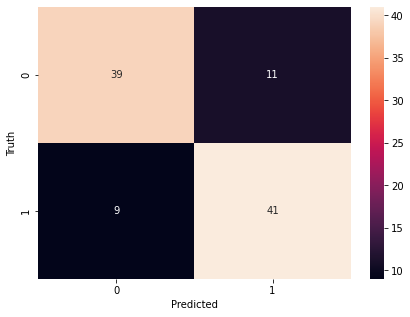

In [52]:
plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred2))


In [53]:
bag_model = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                              n_estimators=100, max_samples=0.8, oob_score=True, random_state=0
                              )
scores = cross_val_score(bag_model, X_train, y_train, cv=5)
bag_model.fit(X_train,y_train)
print(scores)
print(scores.mean())


[0.7125     0.75       0.7125     0.72151899 0.74683544]
0.7286708860759493


              precision    recall  f1-score   support

           0       0.78      0.76      0.77        50
           1       0.76      0.78      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



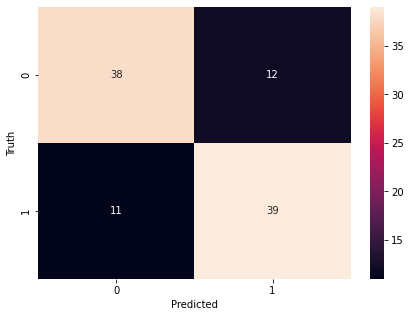

In [54]:
y_pred = bag_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# print(cm)

plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))


In [55]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=50)
model.fit(X_train, y_train)
print(model.score(X_test, y_test))


0.77


              precision    recall  f1-score   support

           0       0.78      0.76      0.77        50
           1       0.76      0.78      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



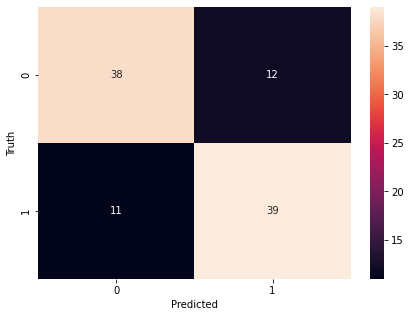

In [56]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# print(cm)

plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))


In [57]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(X_train, y_train)
print(knn.score(X_test, y_test))


0.6


              precision    recall  f1-score   support

           0       0.58      0.72      0.64        50
           1       0.63      0.48      0.55        50

    accuracy                           0.60       100
   macro avg       0.61      0.60      0.59       100
weighted avg       0.61      0.60      0.59       100



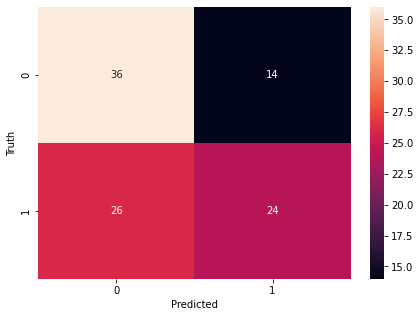

In [58]:
y_pred = knn.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# print(cm)

plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))


In [59]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=50, max_iter=100, tol=0.1)
ridge_reg.fit(X_train, y_train)

print(ridge_reg.score(X_test, y_test))


0.1816073724804721


In [60]:
# from sklearn.model_selection import KFold
# from sklearn.svm import SVC
# scores_l = []
# scores_svm = []
# scores_rf = []

# kf = KFold(n_splits=3)

# for train_index, test_index in kf.split(df):
#     scores_l.append(get_score(LogisticRegression(),
#                     X_train, y_train, X_test, y_test))
#     scores_svm.append(get_score(SVC(), X_train, y_train, X_test, y_test))
#     scores_rf.append(get_score(RandomForestClassifier(),
#                      X_train, y_train, X_test, y_test))

# print(scores_l)
# print(scores_svm)
# print(scores_rf)


In [61]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(n_estimators=40)
model.fit(X_train, y_train)

print(model.score(X_test, y_test))


0.77


              precision    recall  f1-score   support

           0       0.78      0.76      0.77        50
           1       0.76      0.78      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100



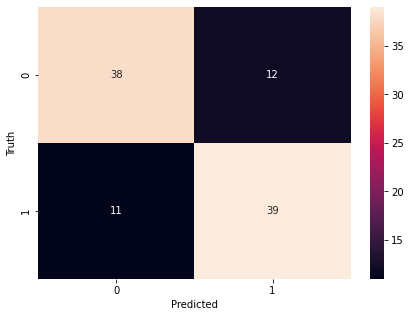

In [62]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# print(cm)

plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))


In [63]:
from sklearn import tree
model=tree.DecisionTreeClassifier()
model.fit(X_train,y_train)

print(model.score(X_test,y_test))

0.71


              precision    recall  f1-score   support

           0       0.72      0.68      0.70        50
           1       0.70      0.74      0.72        50

    accuracy                           0.71       100
   macro avg       0.71      0.71      0.71       100
weighted avg       0.71      0.71      0.71       100



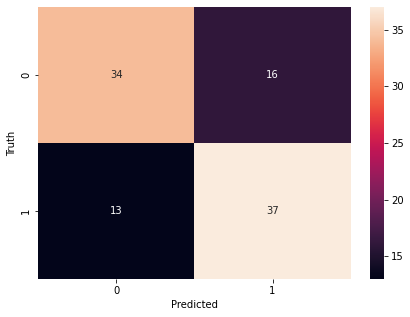

In [64]:
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
# print(cm)

plt.figure(figsize=(7, 5))
sn.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.79      0.76      0.78        50
           1       0.77      0.80      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

              precision    recall  f1-score   support

           0       0.72      0.76      0.74        50
           1       0.74      0.70      0.72        50

    accuracy                           0.73       100
   macro avg       0.73      0.73      0.73       100
weighted avg       0.73      0.73      0.73       100

              precision    recall  f1-score   support

           0       0.78      0.76      0.77        50
           1       0.76      0.78      0.77        50

    accuracy                           0.77       100
   macro avg       0.77      0.77      0.77       100
weighted avg       0.77      0.77      0.77       100

                 mo

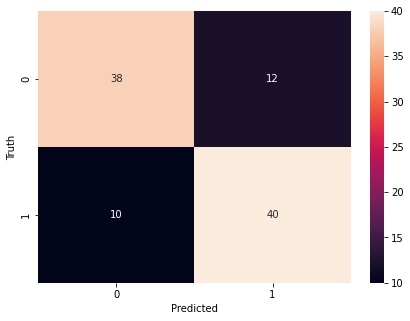

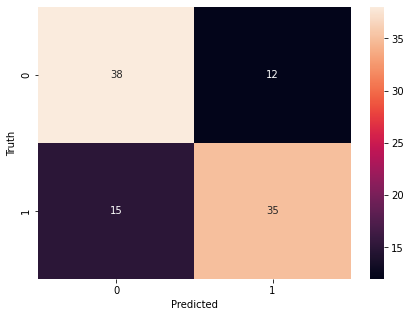

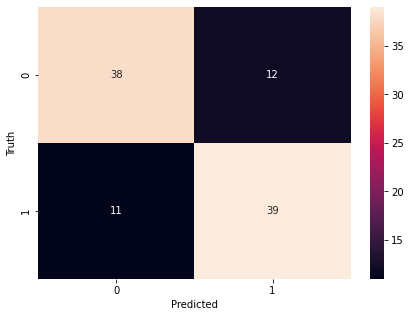

In [65]:
from sklearn.model_selection import GridSearchCV
model_param = {
    'svm': {
        'model': svm.SVC(gamma='auto'),
        'params': {
            'C': [1, 10, 20],
            'kernel': ['rbf', 'linear']
        }
    },
    'random_forest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [1, 5, 10]
        }
    },
    'logistic_regression': {
        'model': LogisticRegression(),
        'params': {
            'C': [1, 5, 10]
        }
    }
}

scores = []
for model_name, mp in model_param.items():
    clf = GridSearchCV(mp['model'], mp['params'],
                       cv=5, return_train_score=False)
    clf.fit(X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })

    y_pred = clf.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    # print(cm)

    plt.figure(figsize=(7, 5))
    sn.heatmap(cm, annot=True)
    plt.xlabel('Predicted')
    plt.ylabel('Truth')
    print(classification_report(y_test, y_pred))

dfr = pd.DataFrame(scores, columns=['model', 'best_score', 'best_params'])
print(dfr)
